<a href="https://colab.research.google.com/github/NumanAloko/ML-for-CFS-Built-up-Columns/blob/main/MLP_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Training and testing of MLP ML model**

In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
############################### Create Dataframe ###############################

# Load the dataset
csv_url= "https://raw.githubusercontent.com/NumanAloko/ML-for-CFS-Built-up-Columns/refs/heads/main/CFS_Built-up_Columns_ML_Dataset.csv"
df = pd.read_csv(csv_url, header=0)
df = df.dropna(how='all').dropna(axis=1, how='all')

# Apply the log transformation to the features and target variable
data_x = np.log(df[['L','t','h','b','KL_r','Py','A','Pne','P(crl_s,crd_s)']])
df['Pt'] = np.log(df['Pt'])

# Create the feature and target DataFrame
y = pd.DataFrame(df,columns=['Pt'])
X = pd.DataFrame(data_x, columns=['L','t','h','b','KL_r','Py','A','Pne','P(crl_s,crd_s)'])

# Data Scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Split the data into training and test sets by the ratio of 70:30.
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_train_index, X_test_index = train_test_split(X_scaled, y_scaled, X.index, test_size=0.3, random_state=123)

In [ ]:
# Define the Multilayer Perceptron (MLP) 0f Artificial Neural Networks model
mlp = MLPRegressor(max_iter=2000,tol =0.0001,random_state=123)

# Hyperparameter tuning based on Grid search method
# Define the parameter grid
#param_grid = {
   #'hidden_layer_sizes': [(50,), (50, 50), (100, 50), (150, 100, 50), (50, 100, 50)],
   #'activation': ['relu', 'tanh'],
   # 'solver': ['adam', 'sgd'],
   # 'alpha': [0.00005, 0.0001, 0.001, 0.01],
   # 'learning_rate': ['constant', 'adaptive'],
   # 'early_stopping': [True],
   # 'validation_fraction': [0.1, 0.2],  # Only relevant if early_stopping is True
   # 'n_iter_no_change': [10, 20]  # Only relevant if early_stopping is True
#}

# Optimised Hyperparameters (Best parameters selected after tuning)
param_grid = {
    'hidden_layer_sizes': [(100,50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [ 0.01],
    'learning_rate': ['constant'],
    'early_stopping': [True],
    'validation_fraction': [0.1, 0.2],  # Only relevant if early_stopping is True
    'n_iter_no_change': [10, 20]  # Only relevant if early_stopping is True
}

#Initialise GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train_scaled.ravel())
best_params = grid_search.best_params_

# Print the best parameters
print(best_params)

{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'n_iter_no_change': 20, 'solver': 'adam', 'validation_fraction': 0.1}


In [ ]:
# Make predictions on the training and test sets
y_pred_mlp_train0 = grid_search.predict(X_train_scaled)
y_pred_mlp_test0 = grid_search.predict(X_test_scaled)

# Reverse the scaling and the log transformation on the predictions
y_pred_mlp_train = pd.DataFrame(np.exp(scaler_y.inverse_transform(y_pred_mlp_train0.reshape(-1, 1))), index=X_train_index, columns=['Predicted'])
y_pred_mlp_test = pd.DataFrame(np.exp(scaler_y.inverse_transform(y_pred_mlp_test0.reshape(-1, 1))), index=X_test_index, columns=['Predicted'])

# Reverse the scaling and the log transformation on the target values
y_train_de = pd.DataFrame(np.exp(scaler_y.inverse_transform(y_train_scaled)), index=X_train_index, columns=['Target'])
y_test_de = pd.DataFrame(np.exp(scaler_y.inverse_transform(y_test_scaled)), index=X_test_index, columns=['Target'])

# Concatenate the training and test predictions/targets and sort by index
y_pred_all = pd.concat([y_pred_mlp_train, y_pred_mlp_test]).sort_index()      # Predictions of MLP Model
y_all = pd.concat([y_train_de, y_test_de]).sort_index()                       # True Target Values

In [ ]:
######################################## Performance Indicators #####################################

# Coefficient of determination (r2)
r2_train = r2_score(y_train_de, y_pred_mlp_train)   # performance of the training set
r2_test = r2_score(y_test_de, y_pred_mlp_test )     # performance of the test set
r2_all = r2_score(y_all, y_pred_all)                # performance of all dataset

# Calculation of RMSE (Root mean squared error) for training data
rmse_train = np.sqrt(mean_squared_error(y_train_de,  y_pred_mlp_train)) # calculate RMSE by taking the square root of MSE
# Calculation of RMSE  (Root mean squared error) for test data
rmse_test = np.sqrt(mean_squared_error(y_test_de,  y_pred_mlp_test)) # calculate RMSE by taking the square root of MSE
# Calculation of RMSE  (Root mean squared error)for all data
rmse_all = np.sqrt(mean_squared_error(y_all, y_pred_all)) # calculate RMSE by taking the square root of MSE
print('r2 score for training = {:8.4f}'.format(r2_train))
print('r2 score for testing = {:8.4f}'.format(r2_test))
print('r2 score for all = {:8.4f}'.format(r2_all))
print('RMSE score for training = {:8.4f}'.format(rmse_train))
print('RMSE score for testing = {:8.4f}'.format(rmse_test))
print('RMSE score for all = {:8.4f}'.format(rmse_all))

# Calculation of ratios of true target values to MLP ML model's predicted values
ratio_train_de = y_train_de.values.ravel() / y_pred_mlp_train.values.ravel()
ratio_test_de = y_test_de.values.ravel() / y_pred_mlp_test.values.ravel()
ratio_all = y_all.values.ravel() / y_pred_all['Predicted'].values.ravel()

# Mean of ratios
mean_ratio_train_de = ratio_train_de.mean(axis=0)
mean_ratio_test_de = ratio_test_de.mean(axis=0)
mean_ratio_all = np.mean(np.abs(ratio_all))

# Standard deviation of ratios
std_ratio_train_de = ratio_train_de.std(axis=0)
std_ratio_test_de = ratio_test_de.std(axis=0)
std_ratio_all = np.std(ratio_all)

# Print mean of ratio
print('Mean of ratio for training (de-normalized) = {:8.4f}'.format(mean_ratio_train_de.mean()))
print('Mean of ratio for testing (de-normalized) = {:8.4f}'.format(mean_ratio_test_de.mean()))
print('mean_ratio_all = {:8.4f}'.format(mean_ratio_all))

# Print standard deviation of ratios
print('Standard deviation of ratio for training (de-normalized) = {:8.4f}'.format(std_ratio_train_de.mean()))
print('Standard deviation of ratio for testing (de-normalized) = {:8.4f}'.format(std_ratio_test_de.mean()))
print('std_ratio_all = {:8.4f}'.format(std_ratio_all))

r2 score for training =   0.9926
r2 score for testing =   0.9861
r2 score for all =   0.9907
RMSE score for training =  10.5239
RMSE score for testing =  14.4851
RMSE score for all =  11.8557
Mean of ratio for training (de-normalized) =   0.9995
Mean of ratio for testing (de-normalized) =   1.0069
mean_ratio_all =   1.0017
Standard deviation of ratio for training (de-normalized) =   0.0692
Standard deviation of ratio for testing (de-normalized) =   0.1041
std_ratio_all =   0.0814


**Make new prediction after training of MLP ML Model**

In [ ]:
#%%
# Make new prediction

# Manually input the new data
new_data = {
    'L': [1500],               # Length(mm)
    't': [1.5],                # Thickness of the section (mm)
    'h': [179],                # Height of the section (mm)
    'b': [67],                 # Flange of the section (mm)
    'KL_r': [29.39],           # Non-dimensioanl member slenderness
    'Py': [418.5],             # Yielding Strength of Section (kN)
    'A': [930],                # Area (mm2) of the section
    'Pne': [393.62],           # Global Buckling Strength of the Section (kN)
    'P(crl_s,crd_s)': [47.74]  # Sectional (Local or Distortional) Buckling Strength of the section (kN)
}

# Create a DataFrame for the new data
new_df = pd.DataFrame(new_data)

# Apply the log transformation to the new data features
new_data_x = np.log(new_df[['L', 't', 'h', 'b', 'KL_r', 'Py', 'A', 'Pne', 'P(crl_s,crd_s)']])

# Scale the new data using the same scaler used for training data
new_data_x_scaled = scaler_x.transform(new_data_x)

# Make predictions on the new data
new_predictions_scaled = grid_search.predict(new_data_x_scaled)

# Reverse the scaling and log transformation on the predictions
new_predictions = np.exp(scaler_y.inverse_transform(new_predictions_scaled.reshape(-1, 1)))

# Create a DataFrame for the predictions
new_predictions_df = pd.DataFrame(new_predictions, columns=['Predicted'])

# Print the predictions
print("Predicted Axial Strength:", new_predictions_df['Predicted'].values)

Predicted Axial Strength: [134.45867919]


**Interpretion of MLP ML model's prediction for new instance**

  0%|          | 0/1 [00:00<?, ?it/s]

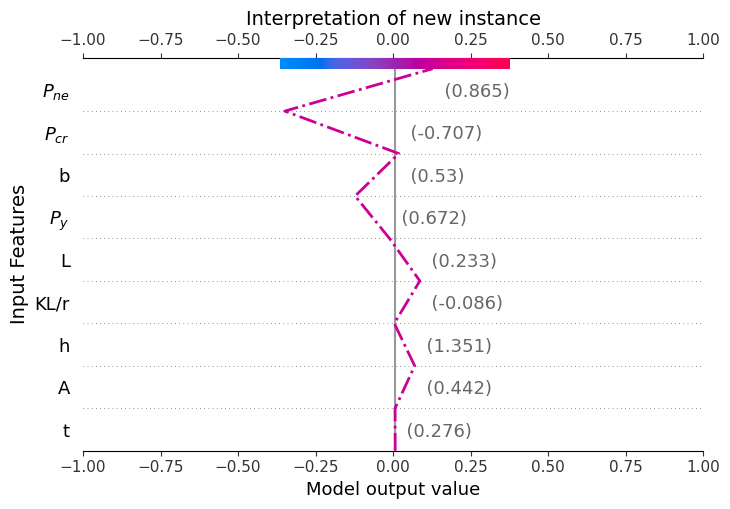

In [ ]:
#%%
# Interpretation of New Instance
import shap

# Initialize the explainer and compute SHAP values for the new input
explainer = shap.KernelExplainer(grid_search.predict, shap.sample(X_train_scaled, 725))
new_shap_values = explainer.shap_values(new_data_x_scaled)

# Convert the new input data to a DataFrame with the new feature names
new_feature_names = ['L', 't', 'h', 'b', 'KL/r', '$P_y$', 'A', '$P_{ne}$', '$P_{cr}$']
new_input_df = pd.DataFrame(new_data_x_scaled, columns=new_feature_names)

# Set the figure size
plt.figure(figsize=(8, 6))

# The decision plot for the new instance
shap.decision_plot(explainer.expected_value, new_shap_values, new_input_df, feature_names=new_feature_names, highlight=0, show=False)

# Get the current figure and axes
fig = plt.gcf()
ax = plt.gca()

# Set the x limits and the y label
ax.set_xlim(-1.0, 1.0)
ax.set_ylabel('Input Features', fontsize=14)
ax.set_title('Interpretation of new instance', fontsize=14)
ax.tick_params(axis='y', direction='out', length=6, width=2, colors='black')

ax.grid(False)

plt.show()